In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4329.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4223.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4253.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4190.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4354.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4136.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4226.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4214.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4888.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4170.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4323.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4262.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4788.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4657.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4387.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4255.jpg
/kaggle/

In [2]:
# ==================== 1. IMPORT LIBRARIES ====================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import os
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# TensorFlow & Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")


2025-11-12 08:07:56.667802: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762934876.694689      94 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762934876.702655      94 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

TensorFlow Version: 2.18.0
GPU Available: []


2025-11-12 08:08:02.439494: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
# ==================== 2. LOAD DATASET ====================

# Jika menggunakan Kaggle Notebook, dataset sudah ada di:
TRAINING_PATH = '/kaggle/input/cat-and-dog/training_set/training_set'
TEST_PATH = '/kaggle/input/cat-and-dog/test_set/test_set'


print(f"Training Path: {TRAINING_PATH}")
print(f"Total files: {len(os.listdir(TRAINING_PATH))}")
print(f"Test Path: {TEST_PATH}")
print(f"Total files: {len(os.listdir(TEST_PATH))}")

# Lihat struktur folder
print("\nStruktur Training Folder:")
for folder in os.listdir(TRAINING_PATH):
    folder_path = os.path.join(TRAINING_PATH, folder)
    if os.path.isdir(folder_path):
        count = len(os.listdir(folder_path))
        print(f"  {folder}: {count} images")

print("\nStruktur Test Folder:")
for folder in os.listdir(TEST_PATH):
    folder_path = os.path.join(TEST_PATH, folder)
    if os.path.isdir(folder_path):
        count = len(os.listdir(folder_path))
        print(f"  {folder}: {count} images")


Training Path: /kaggle/input/cat-and-dog/training_set/training_set
Total files: 2
Test Path: /kaggle/input/cat-and-dog/test_set/test_set
Total files: 2

Struktur Training Folder:
  dogs: 4006 images
  cats: 4001 images

Struktur Test Folder:
  dogs: 1013 images
  cats: 1012 images



Statistik Dataset:
Training - Cats: 4001, Dogs: 4006, Total: 8007
Test - Cats: 1012, Dogs: 1013, Total: 2025


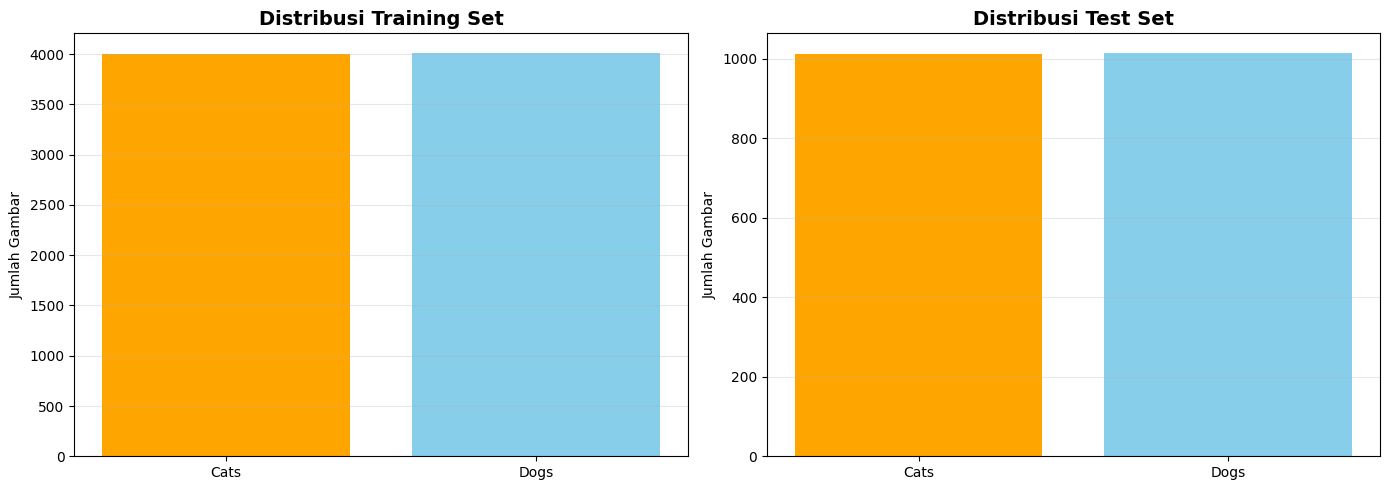

In [4]:
# ==================== 3. EXPLORASI DATA ====================
# Hitung total gambar per kategori
cats_train = len(os.listdir(os.path.join(TRAINING_PATH, 'cats')))
dogs_train = len(os.listdir(os.path.join(TRAINING_PATH, 'dogs')))
cats_test = len(os.listdir(os.path.join(TEST_PATH, 'cats')))
dogs_test = len(os.listdir(os.path.join(TEST_PATH, 'dogs')))

print(f"\nStatistik Dataset:")
print(f"Training - Cats: {cats_train}, Dogs: {dogs_train}, Total: {cats_train + dogs_train}")
print(f"Test - Cats: {cats_test}, Dogs: {dogs_test}, Total: {cats_test + dogs_test}")

# Visualisasi distribusi
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training distribution
axes[0].bar(['Cats', 'Dogs'], [cats_train, dogs_train], color=['orange', 'skyblue'])
axes[0].set_title('Distribusi Training Set', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Jumlah Gambar')
axes[0].grid(axis='y', alpha=0.3)

# Test distribution
axes[1].bar(['Cats', 'Dogs'], [cats_test, dogs_test], color=['orange', 'skyblue'])
axes[1].set_title('Distribusi Test Set', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Jumlah Gambar')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

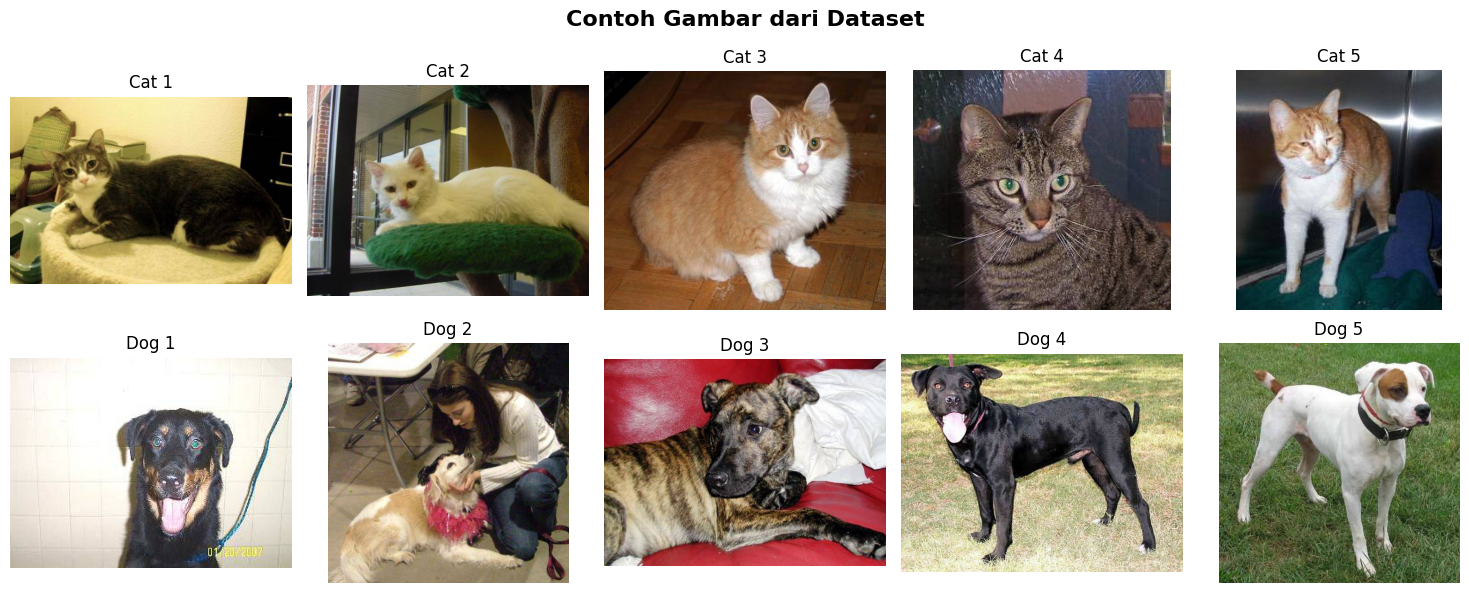

In [5]:
# ==================== 4. VISUALISASI CONTOH GAMBAR ====================
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Contoh Gambar dari Dataset', fontsize=16, fontweight='bold')

# Ambil 5 gambar cats dan 5 gambar dogs dari training set
cats_folder = os.path.join(TRAINING_PATH, 'cats')
dogs_folder = os.path.join(TRAINING_PATH, 'dogs')

cat_images = os.listdir(cats_folder)[:5]
dog_images = os.listdir(dogs_folder)[:5]

for i, img_name in enumerate(cat_images):
    img_path = os.path.join(cats_folder, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Cat {i+1}')
    axes[0, i].axis('off')

for i, img_name in enumerate(dog_images):
    img_path = os.path.join(dogs_folder, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'Dog {i+1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [6]:
# ==================== 5. LOAD & PREPROCESSING DATA ====================
IMG_SIZE = 128  # Ukuran gambar (128x128 untuk efisiensi)

def load_data_from_folders(base_path, limit_per_class=None):
    """
    Load gambar dari struktur folder cats/ dan dogs/
    Args:
        base_path: Path ke folder training_set atau test_set
        limit_per_class: Batasi jumlah gambar per kelas (None = semua)
    """
    data = []
    labels = []
    
    # Load cats (label 0)
    cats_path = os.path.join(base_path, 'cats')
    cat_files = os.listdir(cats_path)
    if limit_per_class:
        cat_files = cat_files[:limit_per_class]
    
    print(f"Loading {len(cat_files)} cat images...")
    for img_name in tqdm(cat_files, desc="Loading cats"):
        try:
            img_path = os.path.join(cats_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img / 255.0  # Normalisasi
            
            data.append(img)
            labels.append(0)  # Cat = 0
        except Exception as e:
            continue
    
    # Load dogs (label 1)
    dogs_path = os.path.join(base_path, 'dogs')
    dog_files = os.listdir(dogs_path)
    if limit_per_class:
        dog_files = dog_files[:limit_per_class]
    
    print(f"Loading {len(dog_files)} dog images...")
    for img_name in tqdm(dog_files, desc="Loading dogs"):
        try:
            img_path = os.path.join(dogs_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img / 255.0  # Normalisasi
            
            data.append(img)
            labels.append(1)  # Dog = 1
        except Exception as e:
            continue
    
    return np.array(data), np.array(labels)

# Load Training Data
print("\n" + "="*50)
print("LOADING TRAINING DATA...")
print("="*50)

# Untuk testing cepat: limit_per_class=1000
# Untuk full training: limit_per_class=None
X_train_full, y_train_full = load_data_from_folders(TRAINING_PATH, limit_per_class=None)

print(f"\nTraining data shape: {X_train_full.shape}")
print(f"Training labels shape: {y_train_full.shape}")

# Load Test Data
print("\n" + "="*50)
print("LOADING TEST DATA...")
print("="*50)

X_test, y_test = load_data_from_folders(TEST_PATH, limit_per_class=None)

print(f"\nTest data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")



LOADING TRAINING DATA...
Loading 4001 cat images...


Loading cats: 100%|██████████| 4001/4001 [01:06<00:00, 60.44it/s]


Loading 4006 dog images...


Loading dogs: 100%|██████████| 4006/4006 [00:53<00:00, 74.85it/s]



Training data shape: (8005, 128, 128, 3)
Training labels shape: (8005,)

LOADING TEST DATA...
Loading 1012 cat images...


Loading cats: 100%|██████████| 1012/1012 [00:12<00:00, 79.27it/s]


Loading 1013 dog images...


Loading dogs: 100%|██████████| 1013/1013 [00:12<00:00, 83.23it/s]



Test data shape: (2023, 128, 128, 3)
Test labels shape: (2023,)


In [7]:
# ==================== 6. SPLIT TRAINING DATA ====================
# Split training data menjadi train (80%) dan validation (20%)
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_train_full
)

print("\n" + "="*50)
print("DATA SPLIT")
print("="*50)
print(f"Train set: {X_train.shape[0]} samples")
print(f"  - Cats: {np.sum(y_train == 0)}")
print(f"  - Dogs: {np.sum(y_train == 1)}")
print(f"\nValidation set: {X_val.shape[0]} samples")
print(f"  - Cats: {np.sum(y_val == 0)}")
print(f"  - Dogs: {np.sum(y_val == 1)}")
print(f"\nTest set: {X_test.shape[0]} samples")
print(f"  - Cats: {np.sum(y_test == 0)}")
print(f"  - Dogs: {np.sum(y_test == 1)}")



DATA SPLIT
Train set: 6404 samples
  - Cats: 3200
  - Dogs: 3204

Validation set: 1601 samples
  - Cats: 800
  - Dogs: 801

Test set: 2023 samples
  - Cats: 1011
  - Dogs: 1012



CONTOH DATA AUGMENTATION


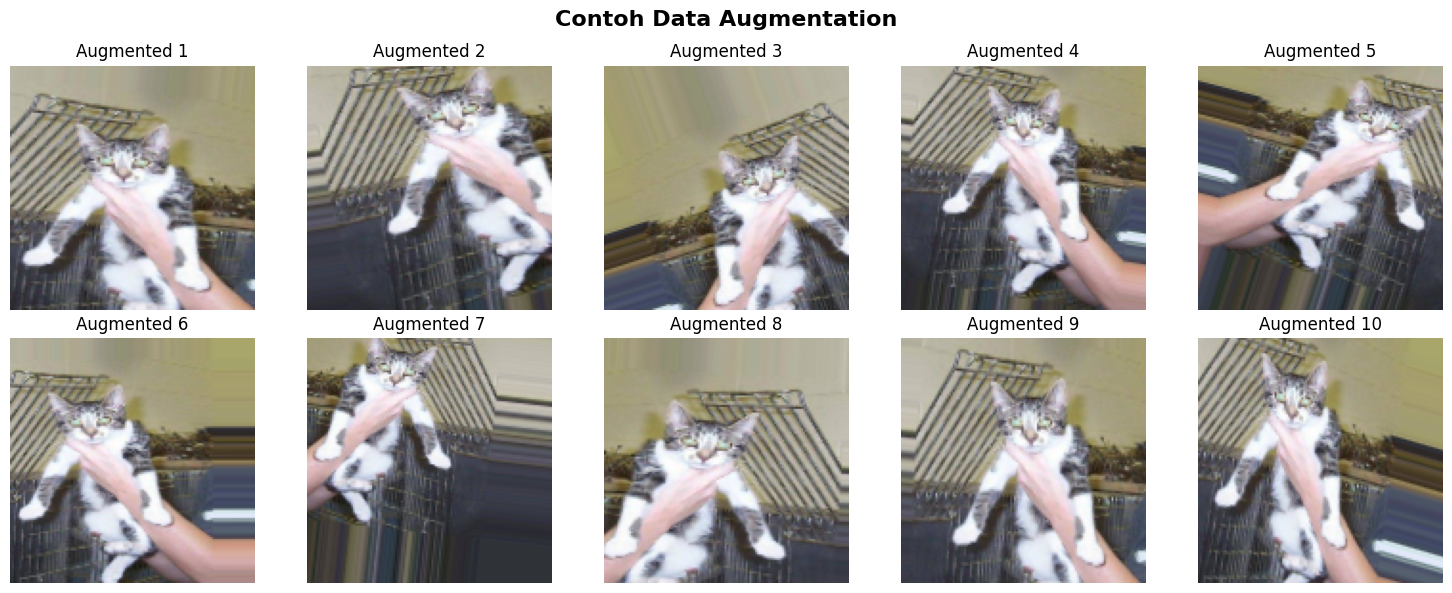

In [8]:
# ==================== 7. DATA AUGMENTATION ====================
BATCH_SIZE = 32

# Augmentasi hanya untuk training data (mencegah overfitting)
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.15,
    fill_mode='nearest'
)

# Visualisasi augmentasi
print("\n" + "="*50)
print("CONTOH DATA AUGMENTATION")
print("="*50)

sample_img = X_train[0].reshape(1, IMG_SIZE, IMG_SIZE, 3)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Contoh Data Augmentation', fontsize=16, fontweight='bold')

for i, ax in enumerate(axes.flat):
    aug_img = train_datagen.flow(sample_img, batch_size=1)[0][0]
    ax.imshow(aug_img)
    ax.axis('off')
    ax.set_title(f'Augmented {i+1}')

plt.tight_layout()
plt.show()

In [9]:
# ==================== 8. MEMBANGUN MODEL CNN ====================
print("\n" + "="*50)
print("MEMBANGUN MODEL CNN")
print("="*50)

def build_cnn_model(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    """
    Membangun model CNN dengan arsitektur yang mencegah overfitting:
    - Batch Normalization
    - Dropout layers
    - L2 Regularization
    """
    model = models.Sequential([
        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                      input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),
        
        # Flatten & Dense Layers
        layers.Flatten(),
        layers.Dense(256, activation='relu', 
                     kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(128, activation='relu',
                     kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # Output Layer (Binary Classification)
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# Build model
model = build_cnn_model()

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()


MEMBANGUN MODEL CNN


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 8,712,225 (33.23 MB)

 Trainable params: 8,710,561 (33.23 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [10]:
# ==================== 9. CALLBACKS ====================
# Callbacks untuk mencegah overfitting dan optimasi training

# Early Stopping: stop jika val_loss tidak improve
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Reduce Learning Rate: kurangi LR jika val_loss plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

# Model Checkpoint: simpan model terbaik
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stop, reduce_lr, checkpoint]


In [11]:
# ==================== 10. TRAINING MODEL ====================
print("\n" + "="*50)
print("TRAINING MODEL")
print("="*50)

EPOCHS = 20  # Akan stop lebih awal jika overfitting (early stopping)

history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\n✓ Training selesai!")



TRAINING MODEL
Epoch 1/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5438 - loss: 1.8259
Epoch 1: val_accuracy improved from -inf to 0.50219, saving model to best_model.h5


201/201 ━━━━━━━━━━━━━━━━━━━━ 538s 3s/step - accuracy: 0.5438 - loss: 1.8259 - val_accuracy: 0.5022 - val_loss: 2.0324 - learning_rate: 0.0010
Epoch 2/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5777 - loss: 1.7930
Epoch 2: val_accuracy improved from 0.50219 to 0.56777, saving model to best_model.h5


201/201 ━━━━━━━━━━━━━━━━━━━━ 520s 3s/step - accuracy: 0.5778 - loss: 1.7928 - val_accuracy: 0.5678 - val_loss: 1.6068 - learning_rate: 0.0010
Epoch 3/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6168 - loss: 1.5106
Epoch 3: val_accuracy improved from 0.56777 to 0.60899, saving model to best_model.h5


201/201 ━━━━━━━━━━━━━━━━━━━━ 521s 3s/step - accuracy: 0.6168 - loss: 1.5102 - val_accuracy: 0.6090 - val_loss: 1.3136 - learning_rate: 0.0010
Epoch 4/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6534 - loss: 1.2322
Epoch 4: val_accuracy improved from 0.60899 to 0.61711, saving model to best_model.h5


201/201 ━━━━━━━━━━━━━━━━━━━━ 535s 3s/step - accuracy: 0.6534 - loss: 1.2321 - val_accuracy: 0.6171 - val_loss: 1.1756 - learning_rate: 0.0010
Epoch 5/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6744 - loss: 1.0654
Epoch 5: val_accuracy improved from 0.61711 to 0.67958, saving model to best_model.h5


201/201 ━━━━━━━━━━━━━━━━━━━━ 543s 3s/step - accuracy: 0.6744 - loss: 1.0653 - val_accuracy: 0.6796 - val_loss: 0.9940 - learning_rate: 0.0010
Epoch 6/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6935 - loss: 0.9694
Epoch 6: val_accuracy improved from 0.67958 to 0.72080, saving model to best_model.h5


201/201 ━━━━━━━━━━━━━━━━━━━━ 528s 3s/step - accuracy: 0.6935 - loss: 0.9692 - val_accuracy: 0.7208 - val_loss: 0.8921 - learning_rate: 0.0010
Epoch 7/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7095 - loss: 0.8851
Epoch 7: val_accuracy did not improve from 0.72080
201/201 ━━━━━━━━━━━━━━━━━━━━ 517s 3s/step - accuracy: 0.7094 - loss: 0.8850 - val_accuracy: 0.6721 - val_loss: 0.8833 - learning_rate: 0.0010
Epoch 8/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7186 - loss: 0.8420
Epoch 8: val_accuracy did not improve from 0.72080
201/201 ━━━━━━━━━━━━━━━━━━━━ 513s 3s/step - accuracy: 0.7186 - loss: 0.8420 - val_accuracy: 0.6577 - val_loss: 0.9164 - learning_rate: 0.0010
Epoch 9/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7160 - loss: 0.8272
Epoch 9: val_accuracy improved from 0.72080 to 0.77264, saving model to best_model.h5


201/201 ━━━━━━━━━━━━━━━━━━━━ 517s 3s/step - accuracy: 0.7160 - loss: 0.8271 - val_accuracy: 0.7726 - val_loss: 0.7605 - learning_rate: 0.0010
Epoch 10/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7198 - loss: 0.8385
Epoch 10: val_accuracy did not improve from 0.77264
201/201 ━━━━━━━━━━━━━━━━━━━━ 513s 3s/step - accuracy: 0.7197 - loss: 0.8385 - val_accuracy: 0.7014 - val_loss: 0.9601 - learning_rate: 0.0010
Epoch 11/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7455 - loss: 0.7868
Epoch 11: val_accuracy did not improve from 0.77264
201/201 ━━━━━━━━━━━━━━━━━━━━ 510s 3s/step - accuracy: 0.7455 - loss: 0.7868 - val_accuracy: 0.7489 - val_loss: 0.8678 - learning_rate: 0.0010
Epoch 12/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7314 - loss: 0.8540
Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: val_accuracy did not improve from 0.77264
201/201 ━━━━━━━━━━━━━━━━━━━━ 561s 3s/step - accuracy: 0.7314 - loss: 0.8539 - val_

201/201 ━━━━━━━━━━━━━━━━━━━━ 510s 3s/step - accuracy: 0.7732 - loss: 0.7550 - val_accuracy: 0.7758 - val_loss: 0.7224 - learning_rate: 5.0000e-04
Epoch 14/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7708 - loss: 0.7084
Epoch 14: val_accuracy improved from 0.77577 to 0.80137, saving model to best_model.h5


201/201 ━━━━━━━━━━━━━━━━━━━━ 512s 3s/step - accuracy: 0.7708 - loss: 0.7084 - val_accuracy: 0.8014 - val_loss: 0.6905 - learning_rate: 5.0000e-04
Epoch 15/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7943 - loss: 0.6949
Epoch 15: val_accuracy did not improve from 0.80137
201/201 ━━━━━━━━━━━━━━━━━━━━ 507s 3s/step - accuracy: 0.7943 - loss: 0.6950 - val_accuracy: 0.7864 - val_loss: 0.7284 - learning_rate: 5.0000e-04
Epoch 16/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7952 - loss: 0.6976
Epoch 16: val_accuracy improved from 0.80137 to 0.81262, saving model to best_model.h5


201/201 ━━━━━━━━━━━━━━━━━━━━ 512s 3s/step - accuracy: 0.7953 - loss: 0.6977 - val_accuracy: 0.8126 - val_loss: 0.7007 - learning_rate: 5.0000e-04
Epoch 17/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8013 - loss: 0.7023
Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 17: val_accuracy did not improve from 0.81262
201/201 ━━━━━━━━━━━━━━━━━━━━ 509s 3s/step - accuracy: 0.8013 - loss: 0.7024 - val_accuracy: 0.7864 - val_loss: 0.7700 - learning_rate: 5.0000e-04
Epoch 18/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8178 - loss: 0.6865
Epoch 18: val_accuracy improved from 0.81262 to 0.85322, saving model to best_model.h5


201/201 ━━━━━━━━━━━━━━━━━━━━ 527s 3s/step - accuracy: 0.8178 - loss: 0.6864 - val_accuracy: 0.8532 - val_loss: 0.5936 - learning_rate: 2.5000e-04
Epoch 19/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8290 - loss: 0.6157
Epoch 19: val_accuracy did not improve from 0.85322
201/201 ━━━━━━━━━━━━━━━━━━━━ 514s 3s/step - accuracy: 0.8290 - loss: 0.6157 - val_accuracy: 0.8470 - val_loss: 0.5809 - learning_rate: 2.5000e-04
Epoch 20/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8477 - loss: 0.5783
Epoch 20: val_accuracy did not improve from 0.85322
201/201 ━━━━━━━━━━━━━━━━━━━━ 516s 3s/step - accuracy: 0.8477 - loss: 0.5783 - val_accuracy: 0.8307 - val_loss: 0.6134 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 19.

✓ Training selesai!



VISUALISASI TRAINING HISTORY


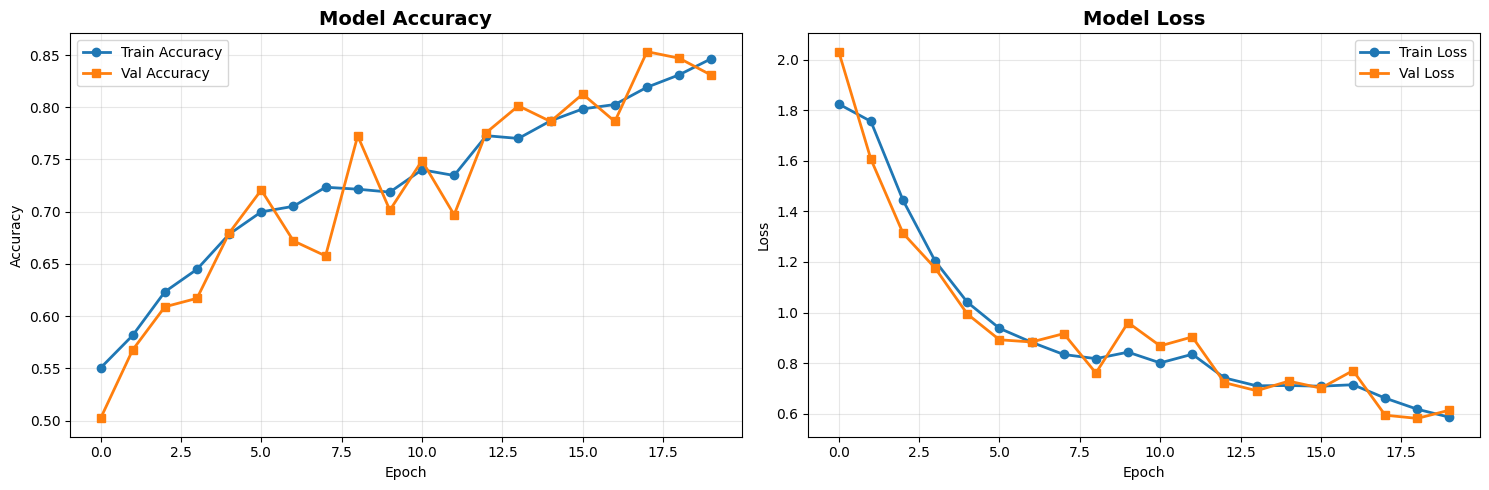

In [12]:
# ==================== 11. VISUALISASI TRAINING HISTORY ====================
print("\n" + "="*50)
print("VISUALISASI TRAINING HISTORY")
print("="*50)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy curve
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2, marker='o')
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2, marker='s')
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Loss curve
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2, marker='o')
axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2, marker='s')
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [13]:
# ==================== 12. EVALUASI MODEL ====================
print("\n" + "="*50)
print("EVALUASI MODEL PADA TEST SET")
print("="*50)

# Prediksi pada test set
y_pred_prob = model.predict(X_test, verbose=1)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Akurasi
test_accuracy = accuracy_score(y_test, y_pred)
print(f"\n✓ Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Classification Report
print("\nClassification Report:")
print("="*50)
target_names = ['Cat (0)', 'Dog (1)']
print(classification_report(y_test, y_pred, target_names=target_names))



EVALUASI MODEL PADA TEST SET
64/64 ━━━━━━━━━━━━━━━━━━━━ 30s 463ms/step

✓ Test Accuracy: 0.8507 (85.07%)

Classification Report:
              precision    recall  f1-score   support

     Cat (0)       0.84      0.87      0.85      1011
     Dog (1)       0.87      0.83      0.85      1012

    accuracy                           0.85      2023
   macro avg       0.85      0.85      0.85      2023
weighted avg       0.85      0.85      0.85      2023




CONFUSION MATRIX


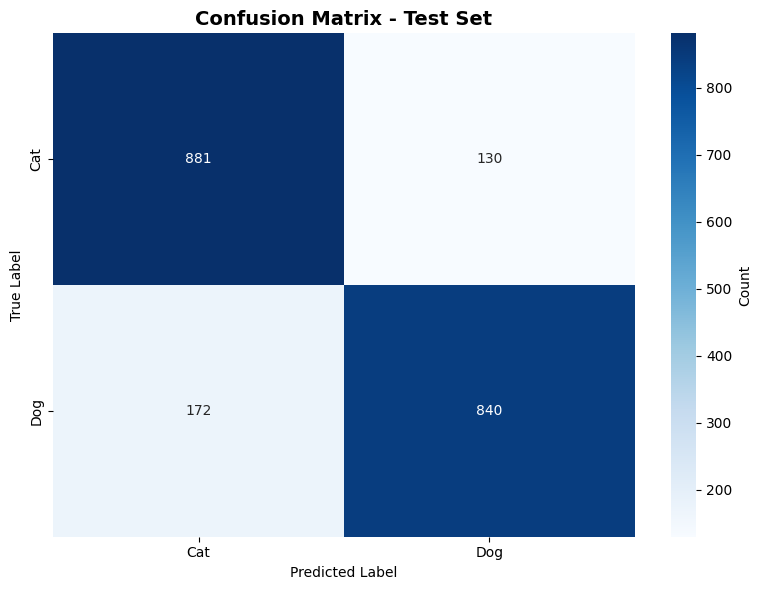


True Negatives (Cat predicted as Cat): 881
False Positives (Cat predicted as Dog): 130
False Negatives (Dog predicted as Cat): 172
True Positives (Dog predicted as Dog): 840

Metrics per Class:
Cat - Precision: 0.8367, Recall: 0.8714
Dog - Precision: 0.8660, Recall: 0.8300


In [ ]:
# ==================== 13. CONFUSION MATRIX ====================
print("\n" + "="*50)
print("CONFUSION MATRIX")
print("="*50)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Cat', 'Dog'],
            yticklabels=['Cat', 'Dog'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Metrics dari confusion matrix
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives (Cat predicted as Cat): {tn}")
print(f"False Positives (Cat predicted as Dog): {fp}")
print(f"False Negatives (Dog predicted as Cat): {fn}")
print(f"True Positives (Dog predicted as Dog): {tp}")

# Hitung metrics tambahan
precision_cat = tn / (tn + fn) if (tn + fn) > 0 else 0
recall_cat = tn / (tn + fp) if (tn + fp) > 0 else 0
precision_dog = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_dog = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"\nMetrics per Class:")
print(f"Cat - Precision: {precision_cat:.4f}, Recall: {recall_cat:.4f}")
print(f"Dog - Precision: {precision_dog:.4f}, Recall: {recall_dog:.4f}")



PREDIKSI CONTOH GAMBAR


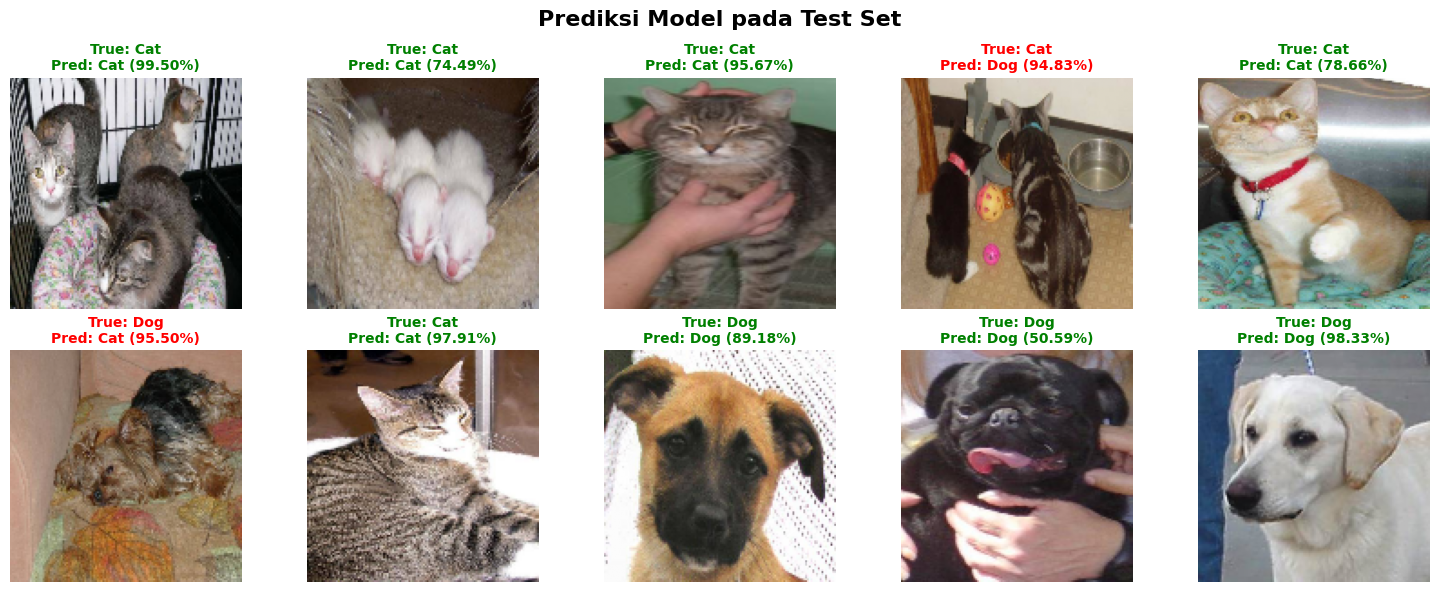

In [ ]:
# ==================== 14. PREDIKSI CONTOH GAMBAR ====================
print("\n" + "="*50)
print("PREDIKSI CONTOH GAMBAR")
print("="*50)

# Ambil 10 sample random dari test set
np.random.seed(42)
indices = np.random.choice(len(X_test), 10, replace=False)
sample_images = X_test[indices]
sample_labels = y_test[indices]
sample_predictions = model.predict(sample_images, verbose=0)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Prediksi Model pada Test Set', fontsize=16, fontweight='bold')

for i, ax in enumerate(axes.flat):
    ax.imshow(sample_images[i])
    
    true_label = 'Dog' if sample_labels[i] == 1 else 'Cat'
    pred_label = 'Dog' if sample_predictions[i] > 0.5 else 'Cat'
    confidence = sample_predictions[i][0] if sample_predictions[i] > 0.5 else 1 - sample_predictions[i][0]
    
    color = 'green' if true_label == pred_label else 'red'
    
    ax.set_title(f'True: {true_label}\nPred: {pred_label} ({confidence:.2%})',
                 color=color, fontweight='bold', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# ==================== 15. SIMPAN MODEL ====================
print("\n" + "="*50)
print("MENYIMPAN MODEL")
print("="*50)

model.save('cats_vs_dogs_cnn_final.h5')
print("✓ Model disimpan sebagai 'cats_vs_dogs_cnn_final.h5'")



MENYIMPAN MODEL
✓ Model disimpan sebagai 'cats_vs_dogs_cnn_final.h5'
